
# Exp. 1 – Help Cost Checking (Python version)

This notebook replicates the R code from the paper *"Deliberating Cost and Impact: Trustworthiness Signals in Punishment and Helping"* for **Experiment 1 (Help Cost Checking)**.

It reproduces:

* Logistic regression: `checking ~ conditionA`
* Predicted probabilities for **Observable** vs **Hidden**
* A bar plot with 95% CI error bars (and significance marker `***`)

Outputs:
- `e1_help_cost_checking_pred.csv` — predicted percentages & CIs  
- `e1_help_cost_checking_plot.png` — plot figure


In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# Load the data
CANDIDATE_PATHS = [

    Path("../data/input/helpcostcheckE1.csv"),
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("Could not find 'helpcostcheckE1.csv'.")

E1 = pd.read_csv(DATA_PATH, sep=";", header=0, dtype=str)


In [10]:


# Try to coerce numeric-like columns (safe conversion)
for col in E1.columns:
    try:
        E1[col] = pd.to_numeric(E1[col])
    except Exception:
        pass

print("Rows, Cols:", E1.shape)
E1.head(10)

Rows, Cols: (2617, 33)


,PID,Duration,A1comp1,A1comp2,A1comp3,A1comp4,A2comp1,A2comp2,A2comp3,A2comp4OB,...,helpUncalc,noUncalc,helpCalc,noCalc,helpedHidB,noHelpdHidB,gender,age,Condition,RecordedDate
0,1,312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,10.0,1,40,6,13/11/2023 18:22
1,2,182,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,42,3,13/11/2023 18:24
2,3,545,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,28,4,13/11/2023 18:26
3,4,364,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,28,3,13/11/2023 18:26
4,5,287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,2.0,1,31,6,13/11/2023 18:27
5,6,335,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,20,4,13/11/2023 18:27
6,7,283,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,30,3,13/11/2023 18:27
7,8,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,10.0,2,40,6,13/11/2023 18:28
8,9,344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,2.0,5.0,2.0,NaN,NaN,2,26,5,13/11/2023 18:28
9,10,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,2.0,10.0,2.0,NaN,NaN,2,25,5,13/11/2023 18:28


In [11]:

# Subset Player A (Condition 3 or 4)
E1["Condition"] = pd.to_numeric(E1["Condition"], errors="coerce")
PlayerA = E1[E1["Condition"].isin([3,4])].copy()

# Select same columns as R: c(1:16, 30:32)
def safe_col_slice(df, positions):
    cols = df.columns
    keep = [cols[p] for p in positions if 0 <= p < len(cols)]
    return df.loc[:, keep]

ae_positions = list(range(0,16)) + list(range(29,32))
PlayerA = safe_col_slice(PlayerA, ae_positions)

# Combine checkObs / checkHid
for c in ["checkObs", "checkHid"]:
    if c not in PlayerA.columns:
        PlayerA[c] = np.nan

PlayerA["checking"] = PlayerA["checkObs"].where(~PlayerA["checkObs"].isna(), PlayerA["checkHid"])
PlayerA["checking"] = pd.to_numeric(PlayerA["checking"], errors="coerce")

# Recreate conditionA (1 = observable (3), 0 = hidden (4))
if "Condition" not in PlayerA.columns:
    PlayerA = PlayerA.join(E1.loc[PlayerA.index, ["Condition"]])
PlayerA["conditionA"] = (PlayerA["Condition"] == 3).astype(int)

# Drop rows with missing dependent variable
PlayerA_model = PlayerA.dropna(subset=["checking", "conditionA"]).copy()


In [4]:

# Logistic regression
X = sm.add_constant(PlayerA_model["conditionA"])
y = PlayerA_model["checking"]
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()

print(res.summary())

# Predictions and confidence intervals
new_exog = pd.DataFrame({"const":[1.0,1.0], "conditionA":[1,0]})
pred = res.get_prediction(new_exog)
sf = pred.summary_frame(alpha=0.05)

plot_df = pd.DataFrame({
    "Condition": ["Observable", "Hidden"],
    "Percentage": sf["mean"].values * 100.0,
    "CI_low": sf["mean_ci_lower"].values * 100.0,
    "CI_high": sf["mean_ci_upper"].values * 100.0
})


                 Generalized Linear Model Regression Results                  
Dep. Variable:               checking   No. Observations:                 1311
Model:                            GLM   Df Residuals:                     1309
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -751.51
Date:                Sun, 02 Nov 2025   Deviance:                       1503.0
Time:                        22:50:11   Pearson chi2:                 1.31e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009292
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2528      0.094     13.350      0.0

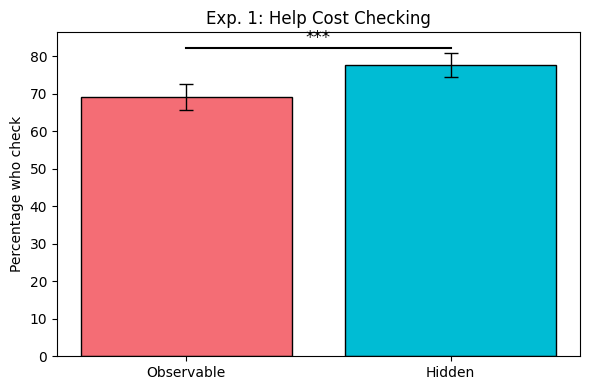

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(plot_df))
vals = plot_df["Percentage"].values
yerr = np.vstack([vals - plot_df["CI_low"].values, plot_df["CI_high"].values - vals])

ax.bar(x, vals, color=["#F46D75", "#00BCD4"], edgecolor="black")
ax.errorbar(x, vals, yerr=yerr, fmt='none', capsize=5, linewidth=1, color="black")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["Condition"])
ax.set_ylabel("Percentage who check")
ax.set_title("Exp. 1: Help Cost Checking")

# Significance marker
y_top = plot_df["CI_high"].max()
pad = (y_top - plot_df["CI_low"].min()) * 0.1
ax.plot([x[0], x[1]], [y_top + pad, y_top + pad], color="black")
ax.text((x[0]+x[1])/2, y_top + pad*1.2, "***", ha="center", va="bottom", fontsize=12)

fig.tight_layout()

# Save
out_tbl = Path("../data/output/e1_help_cost_checking_pred.csv")
out_fig = Path("../data/output/e1_help_cost_checking_plot.png")
plot_df.to_csv(out_tbl, index=False)
fig.savefig(out_fig, dpi=200)